# SGA-PMX Demo

Skrypt przedstawia przykładową implementację algorytmu Simple Genetic Algorithm (SGA) z operatorem PMX i jego zastosowanie do rozwiązywania problemu komiwojażera (ang. Travelling Salesman Problem, TSP). Popularne instancje problemu TSP można znaleźć w bibliotece TSPLib [1]. Skrypt skupia się na rozwiązywaniu instancji BERLIN52, w celu rozwiązywania innych instancji może okazać się konieczna zmiana ustawień parametrów algorytmu, a może też i operatorów ewolucyjnych.

Literatura:

[1] TSPLIB, http://comopt.ifi.uni-heidelberg.de/software/TSPLIB95/

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import time
from functools import partial, reduce
from collections import Counter

def compose(*funcs):
    return reduce(lambda f, g: lambda *args: f(*g(*args)), funcs, lambda *args: args)

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [7]:
from sga import *
from operators import *
from mutations import *
from plot import *

## Input data

In [34]:
# BERLIN52
n = 52


def distance_matrix(n, coords):
    A = np.empty((n, n), dtype=np.float64)
    for i in range(n):
        for j in range(n):
            A[i, j] = np.sqrt(((coords[i, :] - coords[j, :])**2).sum())
    return A


kroa100_coords = np.array([[1380.,  939.],       [2848.,   96.],       [3510., 1671.],       [ 457.,  334.],       [3888.,  666.],       [ 984.,  965.],       [2721., 1482.],       [1286.,  525.],       [2716., 1432.],       [ 738., 1325.],       [1251., 1832.],       [2728., 1698.],       [3815.,  169.],       [3683., 1533.],       [1247., 1945.],       [ 123.,  862.],       [1234., 1946.],       [ 252., 1240.],       [ 611.,  673.],       [2576., 1676.],       [ 928., 1700.],       [  53.,  857.],       [1807., 1711.],       [ 274., 1420.],       [2574.,  946.],       [ 178.,   24.],       [2678., 1825.],       [1795.,  962.],       [3384., 1498.],       [3520., 1079.],       [1256.,   61.],       [1424., 1728.],       [3913.,  192.],       [3085., 1528.],       [2573., 1969.],       [ 463., 1670.],       [3875.,  598.],       [ 298., 1513.],       [3479.,  821.],       [2542.,  236.],       [3955., 1743.],       [1323.,  280.],       [3447., 1830.],       [2936.,  337.],       [1621., 1830.],       [3373., 1646.],       [1393., 1368.],       [3874., 1318.],       [ 938.,  955.],       [3022.,  474.],       [2482., 1183.],       [3854.,  923.],       [ 376.,  825.],       [2519.,  135.],       [2945., 1622.],       [ 953.,  268.],       [2628., 1479.],       [2097.,  981.],       [ 890., 1846.],       [2139., 1806.],       [2421., 1007.],       [2290., 1810.],       [1115., 1052.],       [2588.,  302.],       [ 327.,  265.],       [ 241.,  341.],       [1917.,  687.],       [2991.,  792.],       [2573.,  599.],       [  19.,  674.],       [3911., 1673.],       [ 872., 1559.],       [2863.,  558.],       [ 929., 1766.],       [ 839.,  620.],       [3893.,  102.],       [2178., 1619.],       [3822.,  899.],       [ 378., 1048.],       [1178.,  100.],       [2599.,  901.],       [3416.,  143.],       [2961., 1605.],       [ 611., 1384.],       [3113.,  885.],       [2597., 1830.],       [2586., 1286.],       [ 161.,  906.],       [1429.,  134.],       [ 742., 1025.],       [1625., 1651.],       [1187.,  706.],       [1787., 1009.],       [  22.,  987.],       [3640.,   43.],       [3756.,  882.],       [ 776.,  392.],       [1724., 1642.],       [ 198., 1810.],       [3950., 1558.]])
kroa100_distance = distance_matrix(100, kroa100_coords)

kroa150_coords = np.array([[1380.,  939.],       [2848.,   96.],       [3510., 1671.],       [ 457.,  334.],       [3888.,  666.],       [ 984.,  965.],       [2721., 1482.],       [1286.,  525.],       [2716., 1432.],       [ 738., 1325.],       [1251., 1832.],       [2728., 1698.],       [3815.,  169.],       [3683., 1533.],       [1247., 1945.],       [ 123.,  862.],       [1234., 1946.],       [ 252., 1240.],       [ 611.,  673.],       [2576., 1676.],       [ 928., 1700.],       [  53.,  857.],       [1807., 1711.],       [ 274., 1420.],       [2574.,  946.],       [ 178.,   24.],       [2678., 1825.],       [1795.,  962.],       [3384., 1498.],       [3520., 1079.],       [1256.,   61.],       [1424., 1728.],       [3913.,  192.],       [3085., 1528.],       [2573., 1969.],       [ 463., 1670.],       [3875.,  598.],       [ 298., 1513.],       [3479.,  821.],       [2542.,  236.],       [3955., 1743.],       [1323.,  280.],       [3447., 1830.],       [2936.,  337.],       [1621., 1830.],       [3373., 1646.],       [1393., 1368.],       [3874., 1318.],       [ 938.,  955.],       [3022.,  474.],       [2482., 1183.],       [3854.,  923.],       [ 376.,  825.],       [2519.,  135.],       [2945., 1622.],       [ 953.,  268.],       [2628., 1479.],       [2097.,  981.],       [ 890., 1846.],       [2139., 1806.],       [2421., 1007.],       [2290., 1810.],       [1115., 1052.],       [2588.,  302.],       [ 327.,  265.],       [ 241.,  341.],       [1917.,  687.],       [2991.,  792.],       [2573.,  599.],       [  19.,  674.],       [3911., 1673.],       [ 872., 1559.],       [2863.,  558.],       [ 929., 1766.],       [ 839.,  620.],       [3893.,  102.],       [2178., 1619.],       [3822.,  899.],       [ 378., 1048.],       [1178.,  100.],       [2599.,  901.],       [3416.,  143.],       [2961., 1605.],       [ 611., 1384.],       [3113.,  885.],       [2597., 1830.],       [2586., 1286.],       [ 161.,  906.],       [1429.,  134.],       [ 742., 1025.],       [1625., 1651.],       [1187.,  706.],       [1787., 1009.],       [  22.,  987.],       [3640.,   43.],       [3756.,  882.],       [ 776.,  392.],       [1724., 1642.],       [ 198., 1810.],       [3950., 1558.],       [3477.,  949.],       [  91., 1732.],       [3972.,  329.],       [ 198., 1632.],       [1806.,  733.],       [ 538., 1023.],       [3430., 1088.],       [2186.,  766.],       [1513., 1646.],       [2143., 1611.],       [  53., 1657.],       [3404., 1307.],       [1034., 1344.],       [2823.,  376.],       [3104., 1931.],       [3232.,  324.],       [2790., 1457.],       [ 374.,    9.],       [ 741.,  146.],       [3083., 1938.],       [3502., 1067.],       [1280.,  237.],       [3326., 1846.],       [ 217.,   38.],       [2503., 1172.],       [3527.,   41.],       [ 739., 1850.],       [3548., 1999.],       [  48.,  154.],       [1419.,  872.],       [1689., 1223.],       [3468., 1404.],       [1628.,  253.],       [ 382.,  872.],       [3029., 1242.],       [3646., 1758.],       [ 285., 1029.],       [1782.,   93.],       [1067.,  371.],       [2849., 1214.],       [ 920., 1835.],       [1741.,  712.],       [ 876.,  220.],       [2753.,  283.],       [2609., 1286.],       [3941.,  258.],       [3613.,  523.],       [1754.,  559.],       [2916., 1724.],       [2445., 1820.]])
kroa150_distance = distance_matrix(150, kroa150_coords)

kroa200_coords = np.array([[1357., 1905.],       [2650.,  802.],       [1774.,  107.],       [1307.,  964.],       [3806.,  746.],       [2687., 1353.],       [  43., 1957.],       [3092., 1668.],       [ 185., 1542.],       [ 834.,  629.],       [  40.,  462.],       [1183., 1391.],       [2048., 1628.],       [1097.,  643.],       [1838., 1732.],       [ 234., 1118.],       [3314., 1881.],       [ 737., 1285.],       [ 779.,  777.],       [2312., 1949.],       [2576.,  189.],       [3078., 1541.],       [2781.,  478.],       [ 705., 1812.],       [3409., 1917.],       [ 323., 1714.],       [1660., 1556.],       [3729., 1188.],       [ 693., 1383.],       [2361.,  640.],       [2433., 1538.],       [ 554., 1825.],       [ 913.,  317.],       [3586., 1909.],       [2636.,  727.],       [1000.,  457.],       [ 482., 1337.],       [3704., 1082.],       [3635., 1174.],       [1362., 1526.],       [2049.,  417.],       [2552., 1909.],       [3939.,  640.],       [ 219.,  898.],       [ 812.,  351.],       [ 901., 1552.],       [2513., 1572.],       [ 242.,  584.],       [ 826., 1226.],       [3278.,  799.],       [  86., 1065.],       [  14.,  454.],       [1327., 1893.],       [2773., 1286.],       [2469., 1838.],       [3835.,  963.],       [1031.,  428.],       [3853., 1712.],       [1868.,  197.],       [1544.,  863.],       [ 457., 1607.],       [3174., 1064.],       [ 192., 1004.],       [2318., 1925.],       [2232., 1374.],       [ 396.,  828.],       [2365., 1649.],       [2499.,  658.],       [1410.,  307.],       [2990.,  214.],       [3646., 1018.],       [3394., 1028.],       [1779.,   90.],       [1058.,  372.],       [2933., 1459.],       [3099.,  173.],       [2178.,  978.],       [ 138., 1610.],       [2082., 1753.],       [2302., 1127.],       [ 805.,  272.],       [  22., 1617.],       [3213., 1085.],       [  99.,  536.],       [1533., 1780.],       [3564.,  676.],       [  29.,    6.],       [3808., 1375.],       [2221.,  291.],       [3499., 1885.],       [3124.,  408.],       [ 781.,  671.],       [1027., 1041.],       [3249.,  378.],       [3297.,  491.],       [ 213.,  220.],       [ 721.,  186.],       [3736., 1542.],       [ 868.,  731.],       [ 960.,  303.],       [1380.,  939.],       [2848.,   96.],       [3510., 1671.],       [ 457.,  334.],       [3888.,  666.],       [ 984.,  965.],       [2721., 1482.],       [1286.,  525.],       [2716., 1432.],       [ 738., 1325.],       [1251., 1832.],       [2728., 1698.],       [3815.,  169.],       [3683., 1533.],       [1247., 1945.],       [ 123.,  862.],       [1234., 1946.],       [ 252., 1240.],       [ 611.,  673.],       [2576., 1676.],       [ 928., 1700.],       [  53.,  857.],       [1807., 1711.],       [ 274., 1420.],       [2574.,  946.],       [ 178.,   24.],       [2678., 1825.],       [1795.,  962.],       [3384., 1498.],       [3520., 1079.],       [1256.,   61.],       [1424., 1728.],       [3913.,  192.],       [3085., 1528.],       [2573., 1969.],       [ 463., 1670.],       [3875.,  598.],       [ 298., 1513.],       [3479.,  821.],       [2542.,  236.],       [3955., 1743.],       [1323.,  280.],       [3447., 1830.],       [2936.,  337.],       [1621., 1830.],       [3373., 1646.],       [1393., 1368.],       [3874., 1318.],       [ 938.,  955.],       [3022.,  474.],       [2482., 1183.],       [3854.,  923.],       [ 376.,  825.],       [2519.,  135.],       [2945., 1622.],       [ 953.,  268.],       [2628., 1479.],       [2097.,  981.],       [ 890., 1846.],       [2139., 1806.],       [2421., 1007.],       [2290., 1810.],       [1115., 1052.],       [2588.,  302.],       [ 327.,  265.],       [ 241.,  341.],       [1917.,  687.],       [2991.,  792.],       [2573.,  599.],       [  19.,  674.],       [3911., 1673.],       [ 872., 1559.],       [2863.,  558.],       [ 929., 1766.],       [ 839.,  620.],       [3893.,  102.],       [2178., 1619.],       [3822.,  899.],       [ 378., 1048.],       [1178.,  100.],       [2599.,  901.],       [3416.,  143.],       [2961., 1605.],       [ 611., 1384.],       [3113.,  885.],       [2597., 1830.],       [2586., 1286.],       [ 161.,  906.],       [1429.,  134.],       [ 742., 1025.],       [1625., 1651.],       [1187.,  706.],       [1787., 1009.],       [  22.,  987.],       [3640.,   43.],       [3756.,  882.],       [ 776.,  392.],       [1724., 1642.],       [ 198., 1810.],       [3950., 1558.]])
kroa200_distance = distance_matrix(200, kroa200_coords)


datasets = {
    'kroA100': kroa100_coords,
    'kroA100_distance': kroa100_distance,
    'kroA150': kroa150_coords,
    'kroA150_distance': kroa150_distance,
    'kroA200': kroa200_coords,    
    'kroA200_distance': kroa200_distance,    
}


def load_berlin52(n):
    coords = np.array([565.0, 575.0, 25.0, 185.0, 345.0, 750.0, 945.0, 685.0, 845.0, 655.0, 880.0, 660.0, 25.0, 230.0, 525.0, 1000.0, 580.0, 1175.0, 650.0, 1130.0, 1605.0, 620.0, 1220.0, 580.0, 1465.0, 200.0, 1530.0, 5.0, 845.0, 680.0, 725.0, 370.0, 145.0, 665.0, 415.0, 635.0, 510.0, 875.0, 560.0, 365.0, 300.0, 465.0, 520.0, 585.0, 480.0, 415.0, 835.0, 625.0, 975.0, 580.0, 1215.0, 245.0, 1320.0, 315.0, 1250.0, 400.0, 660.0, 180.0, 410.0, 250.0, 420.0, 555.0, 575.0, 665.0, 1150.0, 1160.0, 700.0, 580.0, 685.0, 595.0, 685.0, 610.0, 770.0, 610.0, 795.0, 645.0, 720.0, 635.0, 760.0, 650.0, 475.0, 960.0, 95.0, 260.0, 875.0, 920.0, 700.0, 500.0, 555.0, 815.0, 830.0, 485.0, 1170.0, 65.0, 830.0, 610.0, 605.0, 625.0, 595.0, 360.0, 1340.0, 725.0, 1740.0, 245.0])
    coords = coords.reshape(n, 2)

    A = distance_matrix(52, coords)

    p = [0, 48, 31, 44, 18, 40,  7,  8,  9, 42, 32, 50, 10, 51, 13, 12, 46, 25, 26, 27, 11, 24,  3,  5, 14,  4, 23, 47, 37, 36, 39, 38, 35, 34, 33, 43, 45, 15, 28, 49, 19, 22, 29,  1,  6, 41, 20, 16,  2, 17, 30, 21]
    return A, coords, p


def load_kroa(n):
    assert(n in [100, 150, 200])
    print('OPT: {}'.format(opts['kroA{}'.format(n)]))

    return datasets['kroA{}_distance'.format(n)]
    
    with open('data/kroA{}.coords'.format(n), 'r') as f:
        data = f.read().splitlines()
    
    coords = list(map(lambda x: x.split(' '), data))
    coords = np.array(coords, dtype=np.float64)
    return distance_matrix(n, coords)


def load_bays29():
    
    with open('data/bays29.matrix', 'r') as f:
        data = f.read().splitlines()    
    return np.array(list(map(lambda l: list(filter(lambda l: l!= '', l.split(' '))), data)), dtype=np.float64)


A, coords, p = load_berlin52(n)
# A = load_kroa(100)
# A = load_bays29()

In [29]:
problem_name = ''

opts = {
    'berlin52': 7542,
    'bayg29': 1610,
    'bays29': 2020,
    'kroA100': 21282,
    'kroA150': 26524,
    'kroA200': 29368,
}

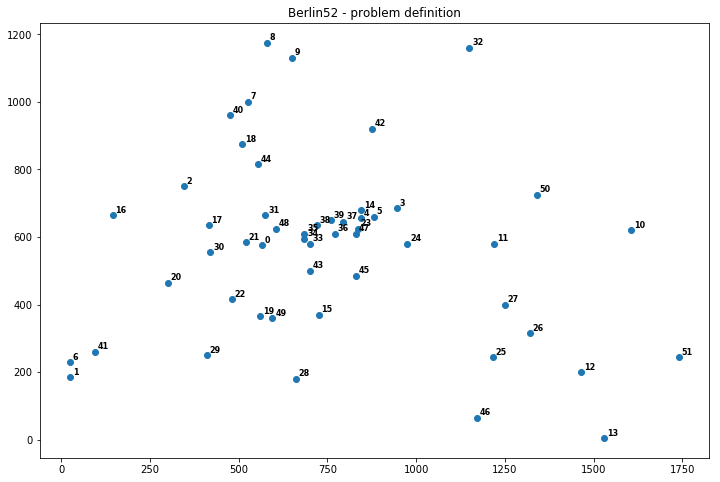

In [5]:
plt.figure(figsize=(12,8))

plt.plot(coords[:, 0], coords[:, 1], 'o')

for i in range(n):
    plt.text(coords[i, 0]+8, coords[i, 1]+8, str(i), fontdict={'weight':'bold', 'size':8})

plt.title('Berlin52 - problem definition')

plt.show()

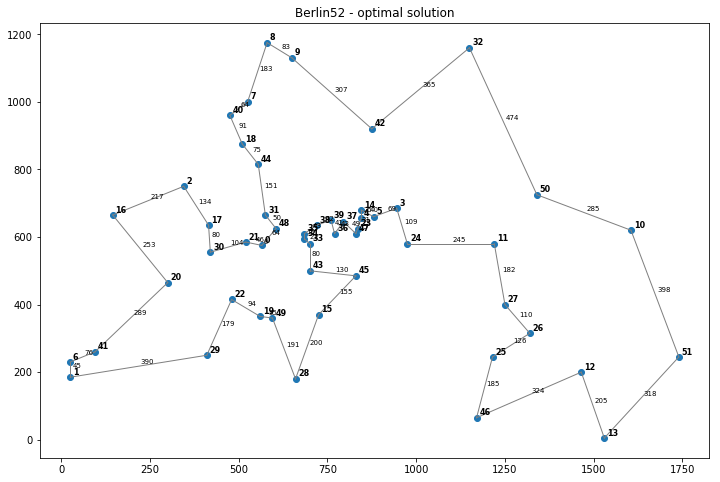

In [6]:
from matplotlib.lines import Line2D

route = p

plt.figure(figsize=(12,8))
fig, ax = plt.subplots(figsize=(12,8))

plt.plot(coords[:, 0], coords[:, 1], 'o')

for i in range(n):
    plt.text(coords[i, 0]+8, coords[i, 1]+8, str(i), fontdict={'weight':'bold', 'size':8})

ax.add_line(Line2D(
    [coords[0, 0], coords[route[0], 0]],
    [coords[0, 1], coords[route[0], 1]],
    linewidth=1, color='gray'))
plt.text((coords[0, 0] + coords[route[0], 0])/2 + 6,
         (coords[0, 1] + coords[route[0], 1])/2 + 6,
         '%d' % A[0, route[0]], fontdict={'weight':'normal', 'size':7})
for i in range(1, len(route)):
    ax.add_line(Line2D(
        [coords[route[i-1], 0], coords[route[i], 0]],
        [coords[route[i-1], 1], coords[route[i], 1]],
        linewidth=1, color='gray'))
    plt.text((coords[route[i-1], 0] + coords[route[i], 0])/2 + 6,
             (coords[route[i-1], 1] + coords[route[i], 1])/2 + 6,
             '%d' % A[route[i-1], route[i]], fontdict={'weight':'normal', 'size':7})
ax.add_line(Line2D(
    [coords[route[-1], 0], coords[0, 0]],
    [coords[route[-1], 1], coords[0, 1]],
    linewidth=1, color='gray'))
plt.text((coords[route[-1], 0] + coords[0, 0])/2 + 6,
         (coords[route[-1], 1] + coords[0, 1])/2 + 6,
         '%d' % A[route[-1], 0], fontdict={'weight':'normal', 'size':7})

plt.title('Berlin52 - optimal solution')

plt.show()

## Objective function

In [16]:
def tsp_objective_function(n, A, perm):
    s = 0.0
    for i in range(n):
        s += A[perm[i-1], perm[i]]
    return s

In [19]:
print(tsp_objective_function(n, A, p), p)

(7544.3659019040861, [0, 48, 31, 44, 18, 40, 7, 8, 9, 42, 32, 50, 10, 51, 13, 12, 46, 25, 26, 27, 11, 24, 3, 5, 14, 4, 23, 47, 37, 36, 39, 38, 35, 34, 33, 43, 45, 15, 28, 49, 19, 22, 29, 1, 6, 41, 20, 16, 2, 17, 30, 21])


## Random Sampling

In [ ]:
t0 = time.time()

T = 1000000
n=52

permutations = np.empty((T, n), dtype=np.int64)
costs = np.zeros(T)
for i in range(T):
    permutations[i, :] = np.random.permutation(n)
    costs[i] = tsp_objective_function(n, A, permutations[i, :])

print(time.time() - t0)

p = permutations[costs.argmin(), :]
print(tsp_objective_function(n, A, p), p)

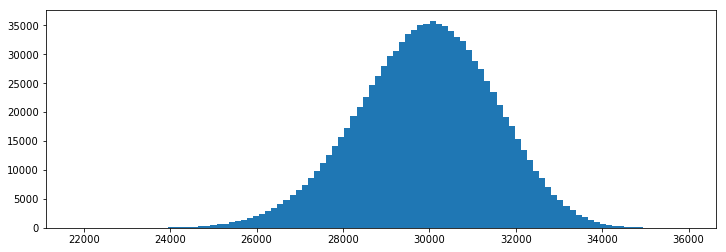

(21830.701996449392, 29913.24959803831, 1579.353206878759)


In [14]:
plt.figure(figsize=(12,4))
plt.hist(costs, bins=100)
plt.show()

print(costs.min(), costs.mean(), costs.std())

## Simulated Annealing

In [15]:
def random_neighbor(p, radius):
    q = p.copy()
    for r in range(radius):
        i, j = np.random.choice(n, 2, replace=False)
        q[i], q[j] = q[j], q[i]
    return q

In [ ]:
T = 500000
n=52
radius = 1
alpha = 1.0

t0 = time.time()

p = np.random.permutation(n)
p_cost = tsp_objective_function(n, A, p)
costs = np.zeros(T)
for t in range(T):
    q = random_neighbor(p, radius)
    q_cost = tsp_objective_function(n, A, q)
    if(q_cost < p_cost):
        p, p_cost = q, q_cost
    elif(np.random.rand() < np.exp(- alpha * (q_cost - p_cost) * t/T)):
        p, p_cost = q, q_cost
    costs[t] = p_cost

print(time.time() - t0, costs.min())

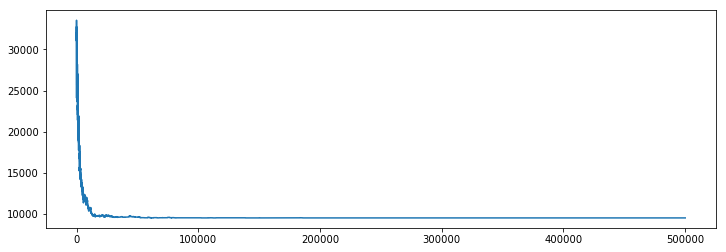

In [17]:
plt.figure(figsize=(12,4))
plt.plot(costs)
plt.show()

## TSP SGA-PMX

  0     0.02789092 min: 24062.21917882 mean: 28454.06824606 max: 29763.36894501 std: 1080.60106143
 20     0.57994890 min: 17471.66309742 mean: 18446.15079614 max: 18710.69750516 std: 225.36963140
 40     2.41321301 min: 13920.87129835 mean: 14409.00217745 max: 14666.59546654 std: 148.83338771
 60     4.00844193 min: 12169.02969939 mean: 12391.51513870 max: 12400.12268798 std:  32.74799599
 80     5.80686593 min: 9957.45886057 mean: 10243.61060500 max: 10305.56116738 std:  90.51229884
100     7.61623001 min: 8942.47587484 mean: 9045.48156410 max: 9046.99113605 std:   7.82882495
120     9.02404189 min: 8348.47000905 mean: 8446.96648563 max: 8461.72100234 std:  25.78403261
140    10.61462498 min: 7974.01127127 mean: 7975.37683279 max: 7979.53666470 std:   2.38338129
160    12.07843304 min: 7700.13723644 mean: 7700.13723644 max: 7700.13723644 std:   0.00000000
180    14.00465703 min: 7700.13723644 mean: 7700.13723644 max: 7700.13723644 std:   0.00000000
199    15.70177889 min: 7700.137236

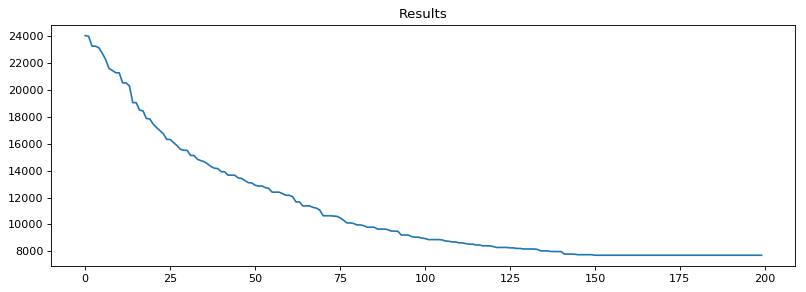

In [15]:
# Berlin52 - reverse_sequence_mutation and identity function as crossover

global problem_name
problem_name = 'berlin52'
params = {
    'T': 200,
    'population_size': 700,
    'chromosome_length': 52,
    'crossover_probability': 0.95,
    'mutation_probability': 0.25,
    'distance_matrix': A,
    'crossover_operator': lambda x, y: (x, y),
    'local_search_probability': 0.001,
    'local_search_k': 2,
    'mutation_operator': reverse_sequence_mutation,    
}

results = sga(**params)

plot_sga_results(problem_name, **results)

  0     0.05922890 min: 25010.72086084 mean: 28491.51320934 max: 29747.34765600 std: 1005.94889961
 10     0.64286995 min: 19932.20152891 mean: 22177.89892996 max: 23075.56266115 std: 750.80196808
 20     1.12145901 min: 16620.15456391 mean: 17530.98035790 max: 17853.16264336 std: 185.53557826
 30     1.48716784 min: 14115.16651209 mean: 14761.35419208 max: 15138.59363510 std: 310.36000794
 40     1.84227300 min: 12340.52037544 mean: 13062.10431195 max: 13247.22526057 std: 172.89122452
 50     2.20840693 min: 11597.34075648 mean: 11903.56807503 max: 12044.87507163 std: 111.74317457
 60     2.56501389 min: 10608.91147362 mean: 11142.54098902 max: 11242.46098240 std: 104.61554851
 70     2.92186594 min: 9629.18161078 mean: 10120.24412973 max: 10235.42449261 std:  92.11445522
 80     3.26259398 min: 9100.46424485 mean: 9231.50473846 max: 9263.65764581 std:  31.01174706
 90     3.59899187 min: 8744.58850817 mean: 8825.22589024 max: 8856.69115543 std:  25.63507130
 99     3.88864684 min: 86

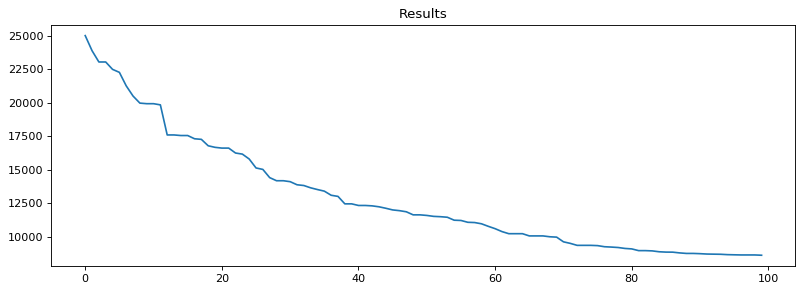

In [21]:
from sga import *

# Berlin52 - PMX as crossover and reverse_sequence_mutation
n = 52
A, _, _ = load_berlin52(n)
global problem_name
problem_name = 'berlin52'
params = {
    'T': 100,
    'population_size': 300,
    'chromosome_length': 52,
    'crossover_probability': 0.95,
    'mutation_probability': 0.25,
    'distance_matrix': A,
    'crossover_operator': pmx_crossover,
    'mutation_operator': reverse_sequence_mutation,
#     'local_search_probability': 0.001,
#     'local_search_k': 3,
    'objective_func': tsp_objective_function,
}

results = sga(**params)

plot_sga_results(problem_name, **results)

  0     0.10811090 min: 24213.66394713 mean: 28433.85534711 max: 29824.72659741 std: 1097.32500536
 20     1.88103795 min: 15297.11886023 mean: 17749.26435675 max: 18464.10313720 std: 643.42765094
 40     6.61644292 min: 12956.98623849 mean: 13473.77638165 max: 13604.53959565 std: 127.12929767
 60    10.98057580 min: 10852.17984739 mean: 11255.40083456 max: 11455.56147947 std: 132.58245237
 80    15.58387685 min: 8822.47211575 mean: 9056.07760612 max: 9092.39225939 std:  43.42301615
100    19.65418386 min: 8344.85892374 mean: 8437.96651919 max: 8438.15602885 std:   4.16857717
120    23.65427995 min: 8202.08903426 mean: 8202.08903426 max: 8202.08903426 std:   0.00000000
140    27.47464299 min: 8160.92275743 mean: 8160.92275743 max: 8160.92275743 std:   0.00000000
160    32.17902398 min: 8153.42648454 mean: 8153.42648454 max: 8153.42648454 std:   0.00000000
180    36.21625590 min: 8153.42648454 mean: 8153.42648454 max: 8153.42648454 std:   0.00000000
199    40.57681084 min: 8153.42648454

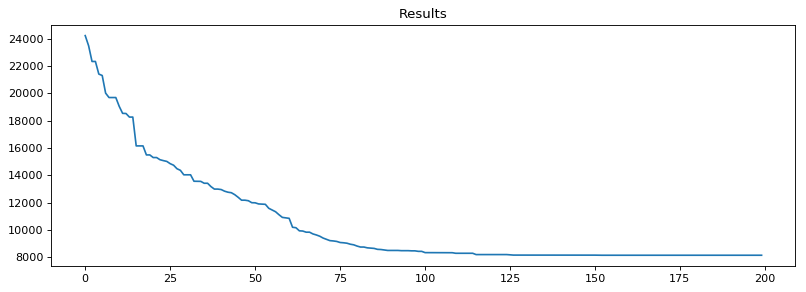

In [70]:
# Berlin52 - PMX and scramble mutation
n = 52
A, _, _ = load_berlin52(n)
global problem_name
problem_name = 'berlin52'
params = {
    'T': 200,
    'population_size': 500,
    'chromosome_length': 52,
    'crossover_probability': 0.95,
    'mutation_probability': 0.15,
    'distance_matrix': A,
    'crossover_operator': pmx_crossover,
    'mutation_operator': reverse_sequence_mutation,    
}

results = sga(**params)

plot_sga_results(problem_name, **results)

  0     0.16479540 min: 23254.44478616 mean: 28438.18211291 max: 29720.18823653 std: 1010.37495207
 20     3.28319955 min: 14971.92225774 mean: 16588.24472204 max: 17039.73527811 std: 351.55609802
 40     6.61198974 min: 10867.49906187 mean: 11647.89738631 max: 11898.24426009 std: 188.24400763
 60     9.80846953 min: 9848.15525290 mean: 10112.67262423 max: 10232.05881864 std:  82.69728093
 80    13.06998944 min: 9206.40961920 mean: 9410.85823781 max: 9467.73089993 std:  47.00004057
100    16.31799245 min: 8865.54652168 mean: 8940.83799309 max: 8954.86047843 std:  11.79301665
120    19.39712143 min: 8438.78183762 mean: 8483.81737677 max: 8499.99545042 std:  16.09520811
140    22.75683570 min: 8212.49300240 mean: 8228.59237537 max: 8236.53675291 std:   5.50286750
160    26.69559503 min: 8140.75924674 mean: 8140.75924674 max: 8140.75924674 std:   0.00000000
180    31.33756900 min: 8140.75924674 mean: 8140.75924674 max: 8140.75924674 std:   0.00000000
199    35.11838889 min: 8140.75924674 

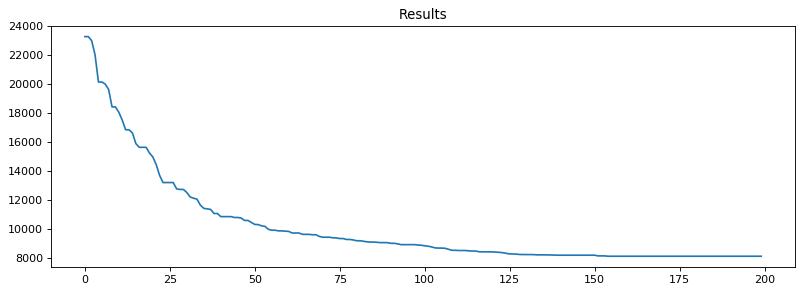

In [48]:
# Berlin52 - OX as crossover and reverse_sequence_mutation

global problem_name
problem_name = 'berlin52'
params = {
    'T': 200,
    'population_size': 700,
    'chromosome_length': 52,
    'crossover_probability': 0.90,
    'mutation_probability': 0.25,
    'distance_matrix': A,
    'crossover_operator': ox_crossover,
    'mutation_operator': reverse_sequence_mutation,    
}

results = sga(**params)

plot_sga_results(problem_name, **results)

In [69]:
# Berlin52 - EX as crossover and reverse_sequence_mutation
n = 52
A, _, _ = load_berlin52(n)
global problem_name
problem_name = 'berlin52'
params = {
    'T': 150,
    'population_size': 700,
    'chromosome_length': 52,
    'crossover_probability': 0.95,
    'mutation_probability': 0.25,
    'distance_matrix': A,
    'crossover_operator': ex_crossover,
    'mutation_operator': reverse_sequence_mutation,    
}

results = sga(**params)

plot_sga_results(problem_name, **results)

  0     1.39930391 min: 23853.77895106 mean: 28326.17709472 max: 29672.65358316 std: 1048.94288964


KeyboardInterrupt: 

In [19]:
# Berlin52 - EX as crossover and scramble mutation
n = 52
A, _, _ = load_berlin52(n)
global problem_name
problem_name = 'berlin52'
params = {
    'T': 150,
    'population_size': 700,
    'chromosome_length': 52,
    'crossover_probability': 0.95,
    'mutation_probability': 0.25,
    'distance_matrix': A,
    'crossover_operator': ex_crossover,
    'mutation_operator': partial(scramble_mutation, 2),    
}

results = sga(**params)

plot_sga_results(problem_name, **results)

TypeError: local_search_mutation() missing 2 required positional arguments: 'k' and 'p'

In [29]:
# Berlin52 - OX o EX as crossover and reverse_sequence_mutation
n = 52
A, _, _ = load_berlin52(n)
global problem_name
problem_name = 'berlin52'
params = {
    'T': 150,
    'population_size': 700,
    'chromosome_length': 52,
    'crossover_probability': 0.80,
    'mutation_probability': 0.30,
    'distance_matrix': A,
    'crossover_operator': compose(ox_crossover, ex_crossover),
    'mutation_operator': reverse_sequence_mutation,    
}

results = sga(**params)

plot_sga_results(problem_name, **results)

  0     0.88714600 min: 24289.06529744 mean: 28264.91281483 max: 29579.24574241 std: 1007.66688283


KeyboardInterrupt: 

  0     1.12898040 min: 24196.40049927 mean: 28443.51071281 max: 29709.22383075 std: 998.00958702
 15    18.32565737 min: 12677.76035313 mean: 14425.65704387 max: 14922.04808233 std: 364.02829755
 30    34.78508544 min: 9714.98619077 mean: 10388.12663422 max: 10638.03898683 std: 224.39371290
 45    50.69475007 min: 8690.93204845 mean: 8812.67235824 max: 8846.96609929 std:  37.38835893
 60    66.35568333 min: 8348.71548578 mean: 8359.73972367 max: 8359.75075894 std:   0.34879145
 75    82.14749575 min: 8261.21999793 mean: 8261.21999793 max: 8261.21999793 std:   0.00000000
 90    98.39573503 min: 8258.75689596 mean: 8258.75689596 max: 8258.75689596 std:   0.00000000
105   115.20760536 min: 8258.75689596 mean: 8258.75689596 max: 8258.75689596 std:   0.00000000
120   130.79469991 min: 8258.75689596 mean: 8258.75689596 max: 8258.75689596 std:   0.00000000
135   146.32288933 min: 8258.75689596 mean: 8258.75689596 max: 8258.75689596 std:   0.00000000
149   160.70644331 min: 8258.75689596 mean

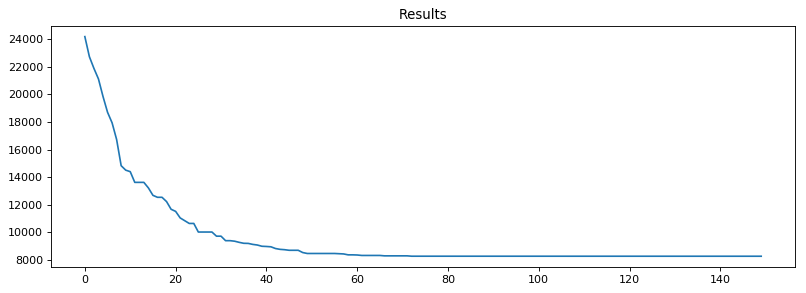

In [33]:
# Berlin52 - EX as crossover and throas_mutation 2
n = 52
A, _, _ = load_berlin52(n)
global problem_name
problem_name = 'berlin52'
params = {
    'T': 150,
    'population_size': 1000,
    'chromosome_length': 52,
    'crossover_probability': 0.90,
    'mutation_probability': 0.35,
    'distance_matrix': A,
    'crossover_operator': ex_crossover,
    'mutation_operator': partial(throas_mutation, 2),
}

results = sga(**params)

plot_sga_results(problem_name, **results)

In [ ]:
# Berlin52 - EX as crossover and throas_mutation 3
n = 52
A, _, _ = load_berlin52(n)
global problem_name
problem_name = 'berlin52'
params = {
    'T': 200,
    'population_size': 700,
    'chromosome_length': 52,
    'crossover_probability': 0.90,
    'mutation_probability': 0.35,
    'distance_matrix': A,
    'crossover_operator': ex_crossover,
    'mutation_operator': partial(throas_mutation, 3),    
}

results = sga(**params)

plot_sga_results(problem_name, **results)

  0     0.22824335 min: 142772.25402092 mean: 163841.47740126 max: 170495.50510470 std: 4993.57054628
 35     6.66297436 min: 85610.48427126 mean: 91907.90962330 max: 94246.80717765 std: 1983.89329468
 70    11.39652801 min: 60564.86945019 mean: 62007.31708999 max: 62278.38121209 std: 283.80260381
105    15.86142445 min: 45786.81198047 mean: 47437.44560075 max: 47728.22593307 std: 263.91626658
140    19.78000259 min: 36377.07975631 mean: 36903.27671193 max: 37013.26560466 std:  97.85246806
175    23.82278538 min: 31916.62038780 mean: 32206.56652260 max: 32247.50347538 std:  61.93316471
210    27.72329855 min: 28805.38541896 mean: 28901.79303436 max: 28932.30189285 std:  33.26372023
245    31.48470950 min: 25762.26799849 mean: 25840.82616634 max: 25949.11034033 std:  90.65141596
280    35.28722906 min: 25511.47483755 mean: 25511.47483755 max: 25511.47483755 std:   0.00000000
315    39.34717464 min: 25408.58028346 mean: 25408.58028346 max: 25408.58028346 std:   0.00000000
349    43.26782

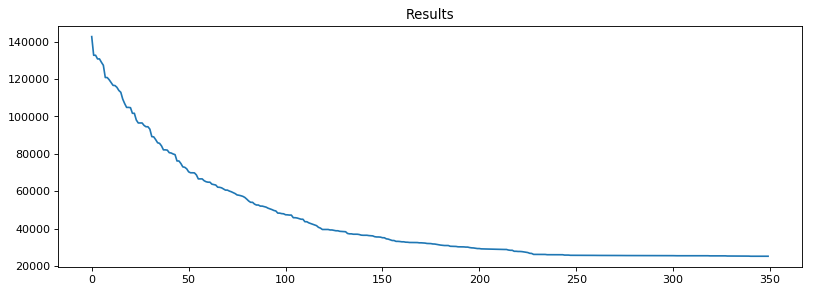

In [49]:
# kroa100 - OX as crossover and reverse_sequence_mutation
n = 100
A = load_kroa(n)
global problem_name
problem_name = 'kroA{n}'.format(n=n)
params = {
    'T': 300,
    'population_size': 800,
    'chromosome_length': n,
    'crossover_probability': 0.95,
    'mutation_probability': 0.20,
    'distance_matrix': A,
    'crossover_operator': ox_crossover,
    'mutation_operator': reverse_sequence_mutation,
}

results = sga(**params)

plot_sga_results(problem_name, **results)

  0     0.34341693 min: 143132.15397903 mean: 163780.41911764 max: 170560.04546167 std: 4800.11726649
 35    15.23298955 min: 95863.17927295 mean: 104371.69593313 max: 108278.22754637 std: 3084.30658920
 70    28.78100944 min: 76908.27414920 mean: 82689.52003965 max: 84455.64568914 std: 1364.03180470
105    41.52174807 min: 62558.90622323 mean: 64248.05879630 max: 65025.55889735 std: 548.35645081
140    53.49384594 min: 50709.86796365 mean: 52109.21437179 max: 52567.94692172 std: 512.61223823
175    64.50212502 min: 41709.03496330 mean: 42352.84428290 max: 42453.61772798 std: 113.38715883
210    75.87234807 min: 35067.14378220 mean: 35582.64037543 max: 35587.37710177 std:  27.52639935
245    86.82819700 min: 31003.13003663 mean: 31197.05006905 max: 31207.90619302 std:  31.24116554
280    97.35365105 min: 27423.22387241 mean: 27462.09407833 max: 27641.73675399 std:  78.81820312
315   107.44097281 min: 26005.59531137 mean: 26034.23305927 max: 26164.69391085 std:  61.12368591
349   117.73

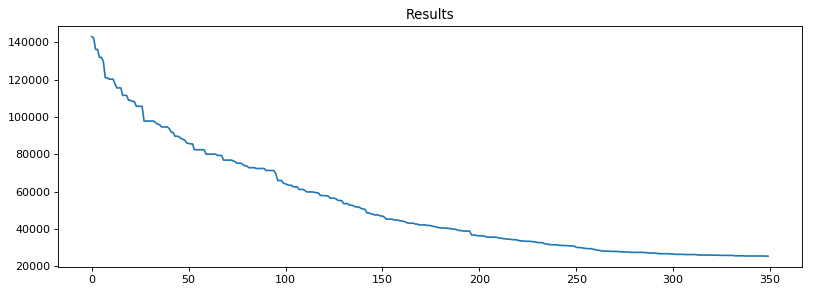

In [22]:
# kroa100 - PMX as crossover and reverse_sequence_mutation
n = 100
A = load_kroa(n)
global problem_name
problem_name = 'kroA{n}'.format(n=n)
params = {
    'T': 300,
    'population_size': 800,
    'chromosome_length': n,
    'crossover_probability': 0.95,
    'mutation_probability': 0.20,
    'distance_matrix': A,
    'crossover_operator': pmx_crossover,
    'mutation_operator': reverse_sequence_mutation,
}

results = sga(**params)

plot_sga_results(problem_name, **results)

  0     1.29952955 min: 145424.47497816 mean: 163071.59202270 max: 169559.56131394 std: 4867.29248237
 20    25.63730741 min: 80252.31564926 mean: 88422.14510692 max: 91443.97338168 std: 2327.24078892
 40    50.44982338 min: 54143.68739725 mean: 61225.74175624 max: 63029.66847748 std: 1550.92403860
 60    74.25734019 min: 47654.81168649 mean: 49233.63462595 max: 49718.21218833 std: 388.33391158
 80   103.35437608 min: 42289.59064640 mean: 42906.40473109 max: 42957.61040248 std:  82.91615642
100   203.55278039 min: 38301.85297084 mean: 39679.39302826 max: 39733.97672948 std: 249.66537281
120   309.54514456 min: 36743.94313809 mean: 36859.90961627 max: 36957.85238919 std:  91.72065761
140   410.63773751 min: 33719.05454368 mean: 34124.99421338 max: 34126.04498551 std:  20.33328250
160   453.16229439 min: 32024.82452863 mean: 32621.27744252 max: 32675.75582665 std: 132.03756119
180   474.57426596 min: 30505.02165035 mean: 30511.44184196 max: 30540.68938156 std:  13.70309485
199   494.9168

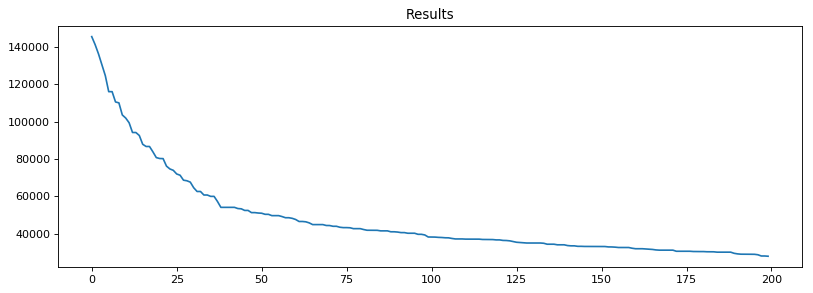

In [52]:
# kroa100 - EX as crossover and throas_mutation 4
n = 100
A = load_kroa(n)
global problem_name
problem_name = 'kroA{n}'.format(n=n)
params = {
    'T': 300,
    'population_size': 800,
    'chromosome_length': n,
    'crossover_probability': 0.85,
    'mutation_probability': 0.35,
    'distance_matrix': A,
    'crossover_operator': ex_crossover,
    'mutation_operator':  partial(throas_mutation, 4),
}

results = sga(**params)

plot_sga_results(problem_name, **results)

In [55]:
# kroa100 - EX as crossover and reverse_sequence_mutation
n = 100
A = load_kroa(n)
global problem_name
problem_name = 'kroA{n}'.format(n=n)
params = {
    'T': 300,
    'population_size': 800,
    'chromosome_length': n,
    'crossover_probability': 0.85,
    'mutation_probability': 0.25,
    'distance_matrix': A,
    'crossover_operator': ex_crossover,
    'mutation_operator': reverse_sequence_mutation,
}

results = sga(**params)

plot_sga_results(problem_name, **results)

  0     1.13965845 min: 144309.83230494 mean: 163295.57150248 max: 169959.09017494 std: 5025.18011751


KeyboardInterrupt: 

  0     0.20487094 min: 224046.22357551 mean: 247207.06846753 max: 255364.69651489 std: 6214.44905979
 40     7.99754691 min: 140298.47708961 mean: 145418.02048702 max: 147493.46942114 std: 1543.99449112
 80    14.19654799 min: 103033.06214853 mean: 106714.98482269 max: 108072.42492408 std: 1186.77844712
120    19.39577818 min: 83272.86264127 mean: 85158.47143082 max: 85947.95888337 std: 539.81294998
160    24.52797055 min: 69800.41574475 mean: 71233.85678901 max: 71561.97994554 std: 302.86186927
200    29.51334858 min: 60471.76310387 mean: 61534.45697773 max: 61746.97346685 std: 245.17204071
240    34.45192719 min: 52059.79379288 mean: 53000.50045325 max: 53319.61879895 std: 356.66585872
280    39.50869894 min: 47859.10164686 mean: 47987.77319842 max: 48003.13599033 std:  27.67469745
320    44.42462397 min: 44721.43297114 mean: 44842.68782945 max: 44935.59392790 std:  29.78433353
360    49.26562572 min: 41757.62936654 mean: 42335.88521301 max: 42438.89129588 std:  97.51379523
399    5

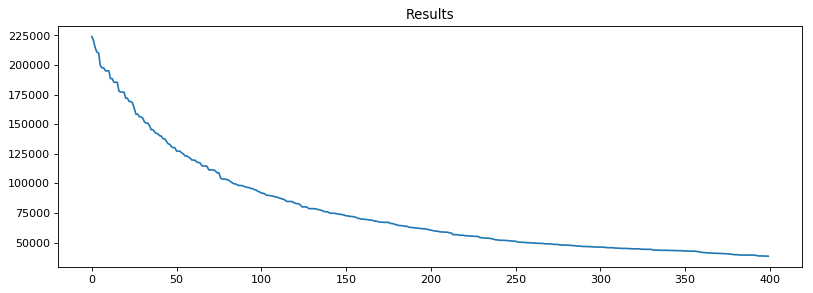

In [317]:
# kroa150 - EX as crossover and reverse_sequence_mutation
n = 150
A = kroa150_distance
global problem_name
problem_name = 'kroA{n}'.format(n=n)
params = {
    'T': 300,
    'population_size': 700,
    'chromosome_length': n,
    'crossover_probability': 0.85,
    'mutation_probability': 0.25,
    'distance_matrix': A,
    'crossover_operator': ex_crossover,
    'mutation_operator': reverse_sequence_mutation,    
}

results = sga(**params)


plot_sga_results(T, problem_name, **results)

In [ ]:
# kroa150 - EX as crossover and reverse_sequence_mutation
n = 150
A = kroa150_distance
global problem_name
problem_name = 'kroA{n}'.format(n=n)
params = {
    'T': 300,
    'population_size': 500,
    'chromosome_length': n,
    'crossover_probability': 0.75,
    'mutation_probability': 0.25,
    'distance_matrix': A,
    'crossover_operator': compose(pmx_crossover, ex_crossover),
    'mutation_operator': reverse_sequence_mutation,    
}

results = sga(**params)


plot_sga_results(T, problem_name, **results)

In [ ]:
# kroa200 - PMX as crossover and reverse_sequence_mutation
n = 200
A = load_kroa(n)
global problem_name
problem_name = 'kroA{n}'.format(n=n)
params = {
    'T': 300,
    'population_size': 600,
    'chromosome_length': n,
    'crossover_probability': 0.90,
    'mutation_probability': 0.20,
    'distance_matrix': A,
    'crossover_operator': pmx_crossover,
    'mutation_operator': reverse_sequence_mutation,    
}

results = sga(**params)


plot_sga_results(problem_name, **results)

  0     0.38820362 min: 305149.28588167 mean: 329985.79520332 max: 339080.96591761 std: 6635.26531704
 25     8.64307284 min: 240658.06045388 mean: 253170.11856245 max: 257202.42441235 std: 3611.16513174
 50    15.68222952 min: 200883.82600937 mean: 210485.73675476 max: 213233.87609981 std: 2017.38710850
 75    21.84168959 min: 174754.09812364 mean: 179885.24306379 max: 181404.03258418 std: 1101.82969461
100    27.53585434 min: 150666.15072485 mean: 155873.29186226 max: 157237.60604814 std: 1123.99729449
125    32.89281273 min: 135201.05335380 mean: 137395.79769309 max: 138227.79989547 std: 640.25443328
150    38.10067153 min: 117964.43259753 mean: 120008.38958930 max: 120527.64795715 std: 466.44417114
175    43.37269306 min: 104619.82162051 mean: 106076.01215582 max: 106576.45369597 std: 305.81504264
200    48.57539988 min: 93236.42435513 mean: 95389.07335294 max: 96002.73862458 std: 517.37940684
225    53.93426108 min: 84981.28909219 mean: 85805.86149529 max: 86193.58602604 std: 293.

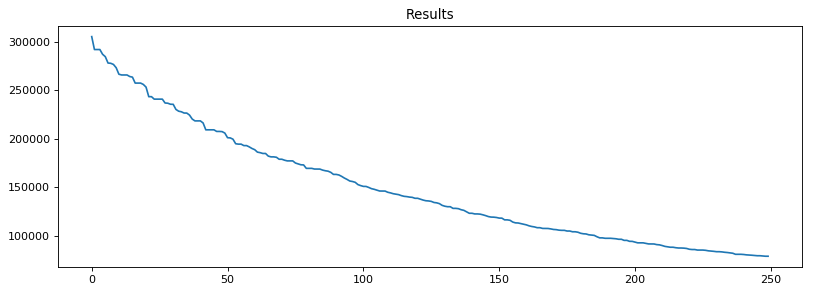

In [13]:
# kroa200 - EX as crossover and reverse_sequence_mutation
n = 200
A = load_kroa(n)
global problem_name
problem_name = 'kroA{n}'.format(n=n)
params = {
    'T': 250,
    'population_size': 600,
    'chromosome_length': n,
    'crossover_probability': 0.90,
    'mutation_probability': 0.20,
    'distance_matrix': A,
    'crossover_operator': pmx_crossover,
    'mutation_operator': reverse_sequence_mutation,    
}

results = sga(**params)


plot_sga_results(problem_name, **results)

  0     0.16872001 min: 4716.00000000 mean: 5625.19500000 max: 5970.00000000 std: 257.33215949
 20     3.21916652 min: 3127.00000000 mean: 3578.97333333 max: 3737.00000000 std: 132.71403828
 40     6.02571201 min: 2275.00000000 mean: 2558.95833333 max: 2657.00000000 std:  77.25388834
 60     8.74278069 min: 2033.00000000 mean: 2033.00000000 max: 2033.00000000 std:   0.00000000
 80    11.35005832 min: 2033.00000000 mean: 2033.00000000 max: 2033.00000000 std:   0.00000000
100    13.80107951 min: 2033.00000000 mean: 2033.00000000 max: 2033.00000000 std:   0.00000000
120    16.45992851 min: 2033.00000000 mean: 2033.00000000 max: 2033.00000000 std:   0.00000000
140    18.99647021 min: 2033.00000000 mean: 2033.00000000 max: 2033.00000000 std:   0.00000000
160    21.54320455 min: 2033.00000000 mean: 2033.00000000 max: 2033.00000000 std:   0.00000000
180    24.17579508 min: 2033.00000000 mean: 2033.00000000 max: 2033.00000000 std:   0.00000000
199    26.65032339 min: 2033.00000000 mean: 2033.0

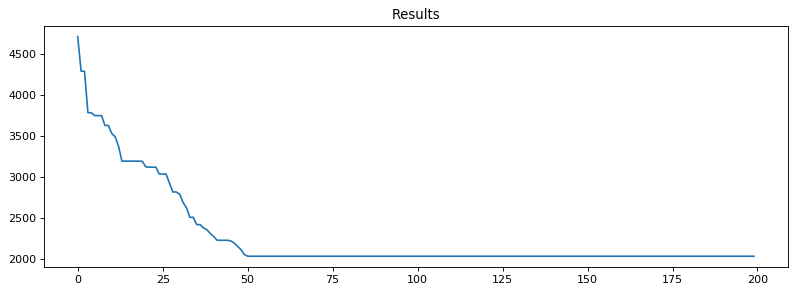

In [36]:
# bays29 - PMX o OX as crossover and reverse_sequence_mutation
n = 29
A = load_bays29()
global problem_name
problem_name = 'bays{n}'.format(n=n)
params = {
    'T': 200,
    'population_size': 600,
    'chromosome_length': n,
    'crossover_probability': 0.90,
    'mutation_probability': 0.25,
    'distance_matrix': A,
    'crossover_operator': compose(pmx_crossover, ox_crossover),
    'mutation_operator': reverse_sequence_mutation,    
}

results = sga(**params)


plot_sga_results(problem_name, **results)

  0     0.38089538 min: 4291.00000000 mean: 5529.44000000 max: 5875.00000000 std: 269.17012539
 10     4.04321003 min: 2642.00000000 mean: 3220.77833333 max: 3375.00000000 std: 119.33920506
 20     7.13976169 min: 2139.00000000 mean: 2319.63166667 max: 2381.00000000 std:  47.74396294
 30    10.09250879 min: 2095.00000000 mean: 2098.87333333 max: 2099.00000000 std:   0.70044430
 40    13.53442550 min: 2095.00000000 mean: 2095.00000000 max: 2095.00000000 std:   0.00000000
 50    17.08162117 min: 2095.00000000 mean: 2095.00000000 max: 2095.00000000 std:   0.00000000
 60    20.76030374 min: 2095.00000000 mean: 2095.00000000 max: 2095.00000000 std:   0.00000000
 70    23.77653766 min: 2095.00000000 mean: 2095.00000000 max: 2095.00000000 std:   0.00000000
 80    27.08912754 min: 2095.00000000 mean: 2095.00000000 max: 2095.00000000 std:   0.00000000
 90    30.42660236 min: 2095.00000000 mean: 2095.00000000 max: 2095.00000000 std:   0.00000000
 99    33.05065560 min: 2095.00000000 mean: 2095.0

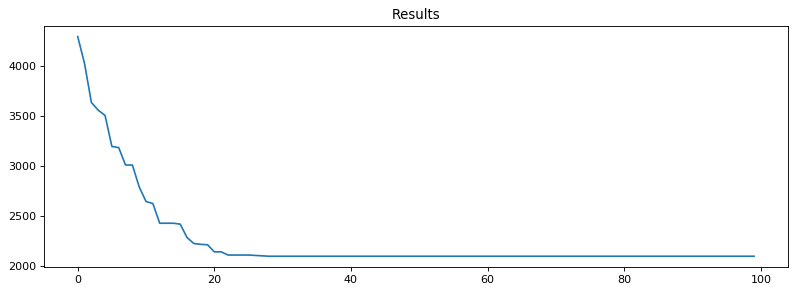

In [35]:
# bays29 - EX as crossover and reverse_sequence_mutation
n = 29
A = load_bays29()
global problem_name
problem_name = 'bays{n}'.format(n=n)
params = {
    'T': 100,
    'population_size': 600,
    'chromosome_length': n,
    'crossover_probability': 0.90,
    'mutation_probability': 0.25,
    'distance_matrix': A,
    'crossover_operator': ex_crossover,
    'mutation_operator': reverse_sequence_mutation,    
}

results = sga(**params)


plot_sga_results(problem_name, **results)

# Local search

In [ ]:
results = {}

OPT: 21282
  0     0.19337296 min: 136208.96623249 mean: 163745.22305587 max: 170144.01400471 std: 4846.73936860
 30     3.65180397 min: 90390.64661172 mean: 94185.04043272 max: 95431.54739440 std: 961.88347700
 60     6.49954486 min: 69599.87915925 mean: 71283.10403255 max: 71508.68524358 std: 374.86980188
 90    39.10887980 min: 53815.90363784 mean: 55943.15568646 max: 56649.11874642 std: 593.87101863
120    79.06345081 min: 44120.17758612 mean: 45086.68252445 max: 45410.69252639 std: 234.76533142
150   112.74912500 min: 38275.19283168 mean: 39289.20397729 max: 39623.72085220 std: 273.58630132
180   150.46617484 min: 33212.77625107 mean: 33574.97839109 max: 33850.52370000 std: 135.22341732
210   184.86769986 min: 28395.54699921 mean: 28758.00516258 max: 28765.02424222 std:  39.00660172
240   220.36516094 min: 26179.57547850 mean: 26207.06731798 max: 26290.87973866 std:  47.93707694
270   257.84285688 min: 25035.29436974 mean: 25139.46048917 max: 25187.83717807 std:  28.20718121
299  

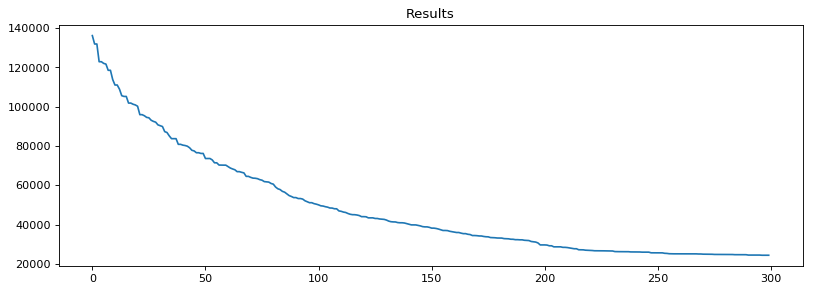

In [37]:
n = 100
A = load_kroa(n)
global problem_name
problem_name = 'kroA{n}'.format(n=n)
params = {
    'T': 500,
    'population_size': 1000,
    'chromosome_length': n,
    'crossover_probability': 0.85,
    'mutation_probability': 0.25,
    'distance_matrix': A,
    'crossover_operator': pmx_crossover,
    'mutation_operator': reverse_sequence_mutation,
    'local_search_probability': 0.01,
    'local_search_k': 30,
}

results[n] = sga(**params)


plot_sga_results(problem_name, **results[n])

In [ ]:
n = 150
A = load_kroa(n)
global problem_name
problem_name = 'kroA{n}'.format(n=n)
params = {
    'T': 500,
    'population_size': 1000,
    'chromosome_length': n,
    'crossover_probability': 0.85,
    'mutation_probability': 0.25,
    'distance_matrix': A,
    'crossover_operator': pmx_crossover,
    'mutation_operator': reverse_sequence_mutation,    
    'local_search_probability': 0.01,
    'local_search_k': 35
}

results[n] = sga(**params)


plot_sga_results(problem_name, **results[n])

In [ ]:
n = 200
A = load_kroa(n)
global problem_name
problem_name = 'kroA{n}'.format(n=n)
params = {
    'T': 500,
    'population_size': 1000,
    'chromosome_length': n,
    'crossover_probability': 0.85,
    'mutation_probability': 0.25,
    'distance_matrix': A,
    'crossover_operator': pmx_crossover,
    'mutation_operator': reverse_sequence_mutation,    
    'local_search_probability': 0.01,
    'local_search_k': 40,
}

results[n] = sga(**params)


plot_sga_results(problem_name, **results[n])

In [ ]:
n = 200
A = load_kroa(n)
global problem_name
problem_name = 'kroA{n}'.format(n=n)
params = {
    'T': 500,
    'population_size': 1000,
    'chromosome_length': n,
    'crossover_probability': 0.85,
    'mutation_probability': 0.25,
    'distance_matrix': A,
    'crossover_operator': ex_crossover,
    'mutation_operator': reverse_sequence_mutation,    
    'local_search_probability': 0.01,
    'local_search_k': 30,
}

results['last'] = sga(**params)


plot_sga_results(problem_name, **results['last'])

Results for kroA100
Min cost: 23393.650715
OPT cost: 21282
Relative error: 9.92%
Absolute error: 2111.65
costs mean: 37718.6654182
costs std: 24308.7557015


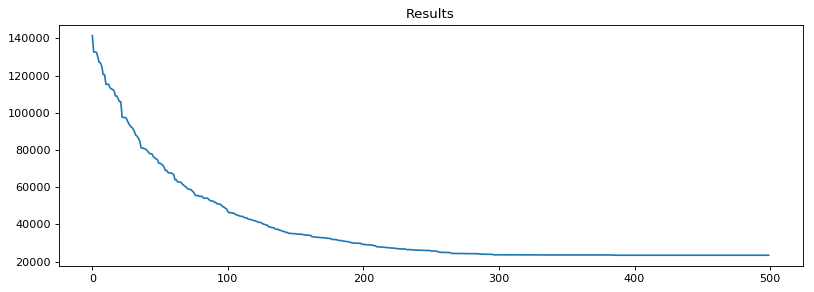

In [46]:
plot_sga_results('kroA100', **results[100])

Results for kroA150
Min cost: 29412.0142785
OPT cost: 26524
Relative error: 10.89%
Absolute error: 2888.01
costs mean: 65105.4166739
costs std: 45988.5338369


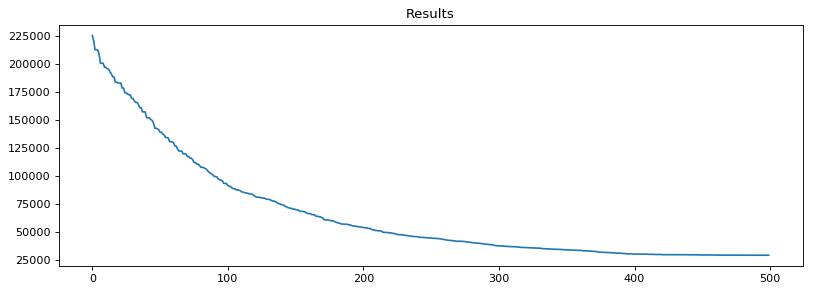

In [47]:
plot_sga_results('kroA150', **results[150])

Results for kroA200
Min cost: 39337.9521268
OPT cost: 29368
Relative error: 33.95%
Absolute error: 9969.95
costs mean: 96506.0039816
costs std: 60131.2668959


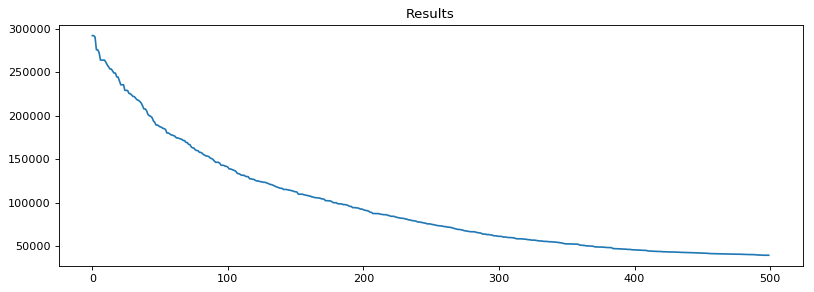

In [49]:
plot_sga_results('kroA200', **results[200])

Results for kroA200
Min cost: 41069.7019814
OPT cost: 29368
Relative error: 39.85%
Absolute error: 11701.7
costs mean: 85451.8716392
costs std: 51316.5856999


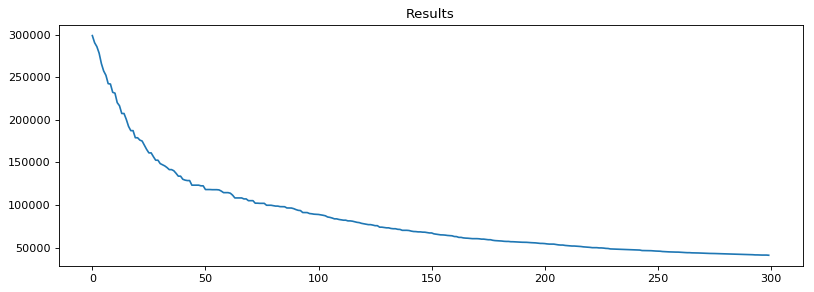

In [50]:
plot_sga_results('kroA200', **results['last'])